# Часть 3. Продолжаем приколы с лингвистическим анализом

Здесь продолжаем анализировать данные с точки зрения лингвистики, выясним, какие слова чаще всего используются в описании разных жанров.

## Сначала импортируем все необходимое и уберем предупреждения

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np
import scipy.stats as sts
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.model_selection import train_test_split
from collections import defaultdict

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

import nltk

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import Counter
from nltk.probability import FreqDist
nltk.download('punkt')

import collections


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [55]:
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (8, 4)

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

## К делу

Приступим к делу и проанализируем, какие слова чаще всего импользуются в описаниях разных жанров

In [60]:
df = pd.read_csv('/content/result.csv')

genres = set()
for genre_list in df['genre']:
    genres.update(genre_list.split(', '))

with open('/content/unmeaning_words.txt', 'r') as file:
    unmeaning_words = file.read().splitlines()
for genre in genres:
    df[genre] = 0
for index, row in df.iterrows():
    genre_list = row['genre'].split(', ')
    for genre in genre_list:
        df.at[index, genre] = 1

# результаты будут тут
top_words_list = []

for genre in genres:
    films = df[df[genre] == 1]['description']
    descriptions = ' '.join(films)
    words = descriptions.lower().split()
    word_counts = collections.Counter(word for word in words if word not in unmeaning_words)
    top_words = word_counts.most_common(12)

    print(genre)
    for word, count in top_words:
        print(word, count)
    print()

Fantasy
against 24
discovers 23
mysterious 22
evil 19
love 19
order 14
school 14
magical 14
group 14
world. 13
dark 13
ancient 12

Mystery
mysterious 44
murder 33
detective 30
group 25
police 25
killer 24
investigate 20
mother 19
death 18
series 18
discover 18
home 18

Action
against 110
group 75
agent 65
war 57
fight 52
mission 51
former 51
mysterious 50
american 49
most 44
protect 43
battle 41

Romance
love 85
school 32
relationship 29
high 27
story 22
love. 21
best 20
couple 20
meet 19
american 19
decides 18
small 17

History
story 25
war 16
american 16
u.s. 10
king 9
battle 8
german 8
most 7
against 7
true 6
early 6
soviet 6

Drama
story 142
love 110
war 95
american 80
father 71
mysterious 70
against 70
york 67
school 64
group 61
teenage 59
high 58

Family
magical 15
story 11
home 11
children 11
father 10
order 10
school 9
evil 9
discover 8
learns 8
group 8
quest 8

Comedy
group 78
school 69
love 64
high 63
york 48
best 46
discovers 42
order 39
story 37
together 35
most 35
against 

### Выводы и наблюдения:

- забавно, что в фентези часто сюжет про школы или античность
- экшн-картины обычно американские (49 упоминаний)
- романсы тоже чаще всего про школы и американских подростков
- Забавно, что в драмах часто (71) фигурируют отцы, но матери в топ не попали
- Семейные фильмы чаще всего магические (15)
- в приключениях и sci-fi часто появляются инопланетяне (39 и там, и там)

## Идем дальше: квинтили и топ-слова

Распределим фильмы по квинтилям на основе оценок и найдем самые попуряные слова для каждого квинтиля. На основе этого попробуем потом предсказать, классный фильм или нет, если в нем есть конкретное слово

In [29]:
np.random.seed(17)

df["imdb_rate"] = df["imdb_rate"].str.replace(',', '.').astype(float)
df_filtered = df[df['votes'] >= 100000]

# Разделение на квинтили по столбцу 'imdb_rate'
df_filtered['quintile'] = pd.qcut(df_filtered['imdb_rate'], q=5, labels=False)

# Вывод границ квинтилей
quintile_boundaries = df_filtered.groupby('quintile')['imdb_rate'].agg(['min', 'max'])
#print(quintile_boundaries)

# Создаем пустые списки для хранения слов по квинтилям
quintile_words = [[] for _ in range(5)]
quintile_words_list = [[] for _ in range(5)]

# Обходим каждую строку в таблице df_filtered
for index, row in df_filtered.iterrows():
    description = row['description'].lower()
    quintile = row['quintile']
    tokens = word_tokenize(description)
    filtered_tokens = [token for token in tokens if token.lower() not in unmeaning_words]
    quintile_words[quintile - 1].extend(filtered_tokens)

# Создаем объекты FreqDist для подсчета частоты слов по квинтилям
freq_dists = [FreqDist(words) for words in quintile_words]

# Выводим 50 самых популярных слов по каждому квинтилю
for quintile, freq_dist in enumerate(freq_dists, start=1):
    print(f"Quintile {quintile}:")
    top_50_words = freq_dist.most_common(15)
    quintile_words_list[quintile-1] = top_50_words
    for word, count in top_50_words:
        print(word, count)
    print()

Quintile 1:
against 21
home 19
murder 18
mysterious 18
most 17
group 16
father 16
agent 16
former 16
`` 16
'' 16
war 16
james 15
school 14
love 14

Quintile 2:
war 28
agent 25
school 20
american 19
mysterious 18
love 18
`` 18
'' 18
earth 17
against 16
story 16
u.s. 15
past 15
father 14
relationship 13

Quintile 3:
love 23
war 22
father 17
home 16
against 16
story 16
york 14
past 14
murder 13
mother 13
way 13
mysterious 13
`` 11
'' 11
former 11

Quintile 4:
war 27
story 26
against 22
love 18
american 16
home 15
mysterious 15
father 14
former 14
its 13
old 13
future 13
group 13
sent 13
wife 12

Quintile 5:
against 34
earth 33
group 30
order 28
race 21
father 19
home 18
mysterious 17
agent 17
york 17
evil 16
death 16
discovers 15
love 15
war 15



### Убираем пересечения

А теперь выведеми самые популярыне слова в квинтилях, не встречающиеся среди 100 самых популярных слова в других квинтилях

In [33]:
np.random.seed(17)
top_words_count = 100
quintile_top_words = [[] for _ in range(5)]
quintile_top_words_list = [[] for _ in range(5)]


# Обходим каждую строку в таблице df_filtered
for index, row in df_filtered.iterrows():
    description = row['description'].lower()
    quintile = row['quintile']
    tokens = word_tokenize(description)
    filtered_tokens = [token for token in tokens if token.lower() not in unmeaning_words]
    fdist = FreqDist(filtered_tokens)

    # Получаем список самых популярных слов
    top_words = [word for word, _ in fdist.most_common(top_words_count)]

    # Добавляем список самых популярных слов в соответствующий список квинтиля
    quintile_top_words[quintile - 1].extend(top_words)


for i in range (0, 5):
    # Создаем словарь с подсчетом частоты встречаемости слов
    word_counter = collections.Counter(quintile_top_words[i])

    # Находим 50 самых часто встречающихся слов
    top_words = word_counter.most_common(top_words_count)
    quintile_top_words_list[i] = top_words


# Создаем новый массив со списками слов без чисел
words_list = [[pair[0] for pair in sublist] for sublist in quintile_top_words_list]

merged_list = []
for sublist in words_list:
    merged_list.extend(sublist)

unique_words = []
for word in merged_list:
    if merged_list.count(word) == 1:
        unique_words.append(word)

filtered_list = [[word for word in sublist if word in unique_words] for sublist in words_list]

for i in range (1,6):
    print(f"Quintile {i}:")
    print(filtered_list[i-1])
    print()


Quintile 1:
['james', 'identity', 'powers', 'vengeful', 'land', 'real', 'kill', 'conspiracy', 'mystery', 'decide', 'involving', 'fighter', 'bring', 'night', 'case', 'book']

Quintile 2:
['plan', 'bank', 'brothers', 'sister', 'prince', '(', ')', 'some', 'join', 'prison', 'turns', 'children', 'female', 'along', 'russian', 'london', 'something', 'president', 'six', 'seeks']

Quintile 3:
['lawyer', 'accused', 'friendship', 'makes', 'trip', 'late', 'follows', 'michael', 'violent', 'uses', 'struggle', 'harry', 'turned', 'haunted', 'california', 'england', 'gang', 'road', 'age', 'ordinary', 'superhero', 'teenager', 'legendary', 'boss', 'year']

Quintile 4:
['search', 'journey', 'empire', 'violence', 'destroy', 'jewish', 'star', 'dead', 'powerful', 'power', 'track', 'boxer', 'german', 'despite', 'british', 'wrong', 'troubled', 'known', 'corruption', 'ring', 'reality', 'murdered', 'music', 'determined', 'country', 'film']

Quintile 5:
['deadly', 'plot', 'return', 'ancient', 'space', 'form', 'hu

### Предположения

Дальше мы хотим сделать несколько предположений о том, как слова лияют на рейтинг фильма, а для этого посмотреть, как распределены фильмы по квинтилям по ключевым словам.

Рассмотрим три варианта:
- упоминания цветов: красный, белый, черный
- упоминания родственников: мать, отец, брат, сестра
- упоминания наших выбранных слов про любовь, приключения, смерть и войну
- упоминания регионов Америки, тк по предыдущим результатам видно, что они часто встречаются

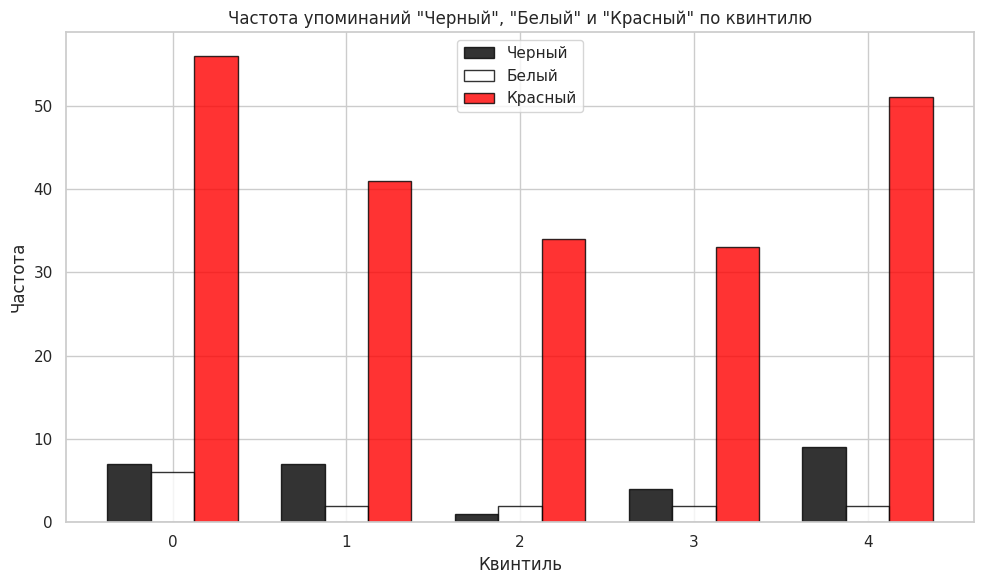

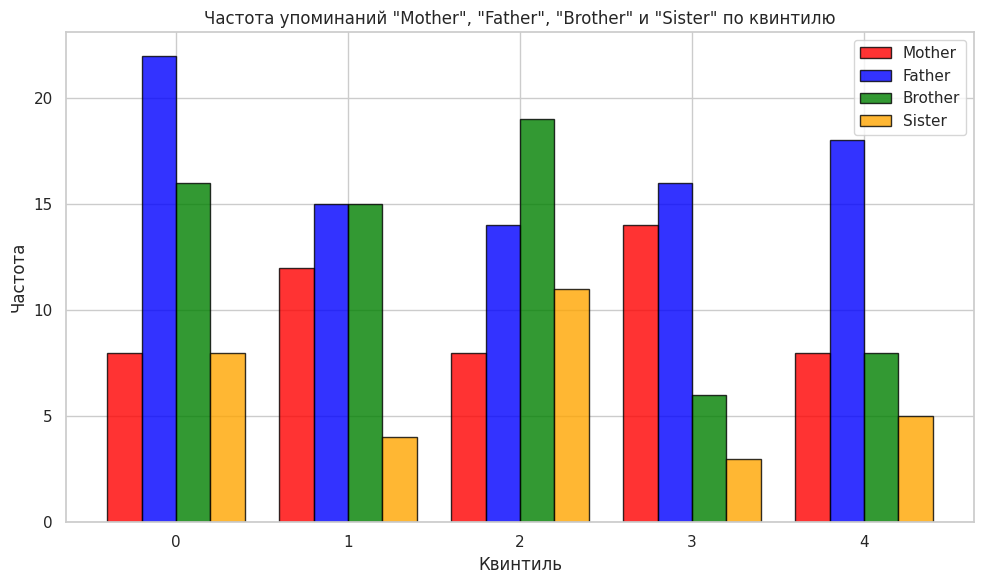

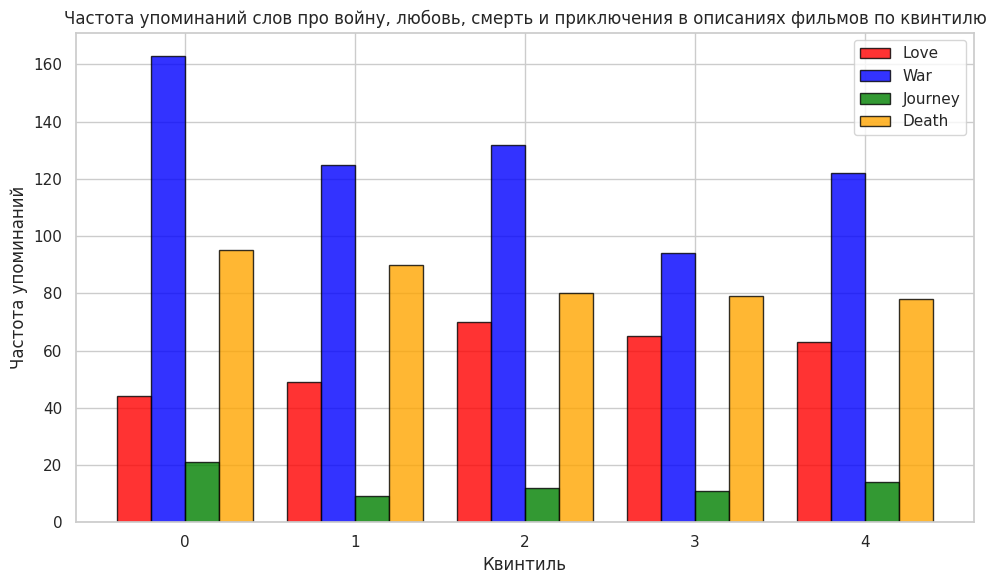

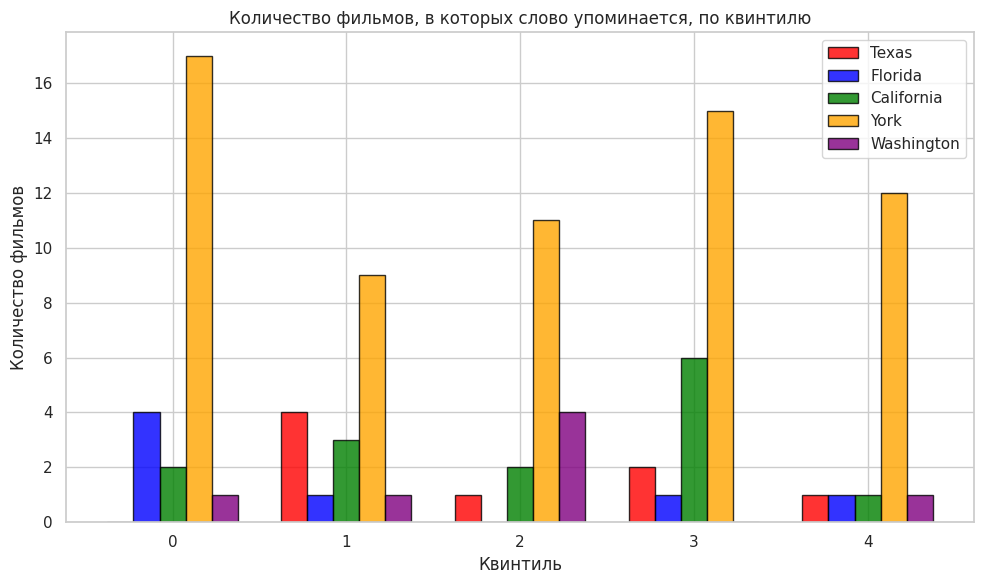

In [34]:
# №5 вывожу гистограмму популярности разных слов по квантилям


np.random.seed(17)

with open('/content/love_words.txt', 'r') as file:
    love_word_list = file.read().splitlines()

with open('/content/death_words.txt', 'r') as file:
    death_word_list = file.read().splitlines()

with open('/content/war_words.txt', 'r') as file:
    war_word_list = file.read().splitlines()

with open('/content/journey_words.txt', 'r') as file:
    journey_word_list = file.read().splitlines()


# Предполагая, что df_filtered - это ваша таблица с данными, содержащая столбцы 'description' и 'quintile'

# Преобразуем описание к нижнему регистру
df_filtered['description'] = df_filtered['description'].str.lower()

# Фильтруем таблицу для слов 'черный', 'белый' и 'красный' в описаниях
df_filtered_black = df_filtered[df_filtered['description'].str.contains('black', case=False)]
df_filtered_white = df_filtered[df_filtered['description'].str.contains('white', case=False)]
df_filtered_red = df_filtered[df_filtered['description'].str.contains('red', case=False)]

# Группируем отфильтрованные таблицы по 'quintile' и считаем количество упоминаний
black_counts = df_filtered_black['quintile'].value_counts().sort_index()
white_counts = df_filtered_white['quintile'].value_counts().sort_index()
red_counts = df_filtered_red['quintile'].value_counts().sort_index()

# Строим гистограмму
fig, ax = plt.subplots(figsize=(10, 6))
index = black_counts.index
bar_width = 0.25
opacity = 0.8

rects1 = ax.bar(index, black_counts, bar_width,
                alpha=opacity, color='black', edgecolor='black', label='Черный')
rects2 = ax.bar(index + bar_width, white_counts, bar_width,
                alpha=opacity, color='white', edgecolor='black', label='Белый')
rects3 = ax.bar(index + 2 * bar_width, red_counts, bar_width,
                alpha=opacity, color='red', edgecolor='black', label='Красный')

ax.set_xlabel('Квинтиль')
ax.set_ylabel('Частота')
ax.set_title('Частота упоминаний "Черный", "Белый" и "Красный" по квинтилю')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(index)
ax.legend()

plt.tight_layout()
plt.show()

#__________________________________

# Фильтруем таблицу для слов 'mother', 'father', 'brother' и 'sister' в описаниях
df_filtered_mother = df_filtered[df_filtered['description'].str.contains('mother', case=False)]
df_filtered_father = df_filtered[df_filtered['description'].str.contains('father', case=False)]
df_filtered_brother = df_filtered[df_filtered['description'].str.contains('brother', case=False)]
df_filtered_sister = df_filtered[df_filtered['description'].str.contains('sister', case=False)]

# Группируем отфильтрованные таблицы по 'quintile' и считаем количество упоминаний
mother_counts = df_filtered_mother['quintile'].value_counts().sort_index()
father_counts = df_filtered_father['quintile'].value_counts().sort_index()
brother_counts = df_filtered_brother['quintile'].value_counts().sort_index()
sister_counts = df_filtered_sister['quintile'].value_counts().sort_index()

# Строим гистограмму
fig, ax = plt.subplots(figsize=(10, 6))
index = mother_counts.index
bar_width = 0.2
opacity = 0.8

rects1 = ax.bar(index - 1.5 * bar_width, mother_counts, bar_width,
                alpha=opacity, color='red', edgecolor='black', label='Mother')
rects2 = ax.bar(index - 0.5 * bar_width, father_counts, bar_width,
                alpha=opacity, color='blue', edgecolor='black', label='Father')
rects3 = ax.bar(index + 0.5 * bar_width, brother_counts, bar_width,
                alpha=opacity, color='green', edgecolor='black', label='Brother')
rects4 = ax.bar(index + 1.5 * bar_width, sister_counts, bar_width,
                alpha=opacity, color='orange', edgecolor='black', label='Sister')

ax.set_xlabel('Квинтиль')
ax.set_ylabel('Частота')
ax.set_title('Частота упоминаний "Mother", "Father", "Brother" и "Sister" по квинтилю')
ax.set_xticks(index)
ax.set_xticklabels(index)
ax.legend()

plt.tight_layout()
plt.show()

#__________________

# Функция для подсчета количества упоминаний слов в описаниях
def count_word_mentions(word_list):
    return df_filtered['description'].apply(lambda x: sum(1 for word in word_list if word in x)).values

# Создаем столбцы с количеством упоминаний слов
df_filtered['love_mentions'] = count_word_mentions(love_word_list)
df_filtered['war_mentions'] = count_word_mentions(war_word_list)
df_filtered['journey_mentions'] = count_word_mentions(journey_word_list)
df_filtered['death_mentions'] = count_word_mentions(death_word_list)

# Группируем таблицу по 'quintile' и суммируем количество упоминаний слов
word_counts = df_filtered.groupby('quintile')[['love_mentions', 'war_mentions', 'journey_mentions', 'death_mentions']].sum()

# Строим гистограмму
fig, ax = plt.subplots(figsize=(10, 6))  # Измените размер графика по вашему усмотрению
index = word_counts.index
bar_width = 0.2
opacity = 0.8

rects1 = ax.bar(index - 1.5 * bar_width, word_counts['love_mentions'], bar_width,
                alpha=opacity, color='red', edgecolor='black', label='Love')
rects2 = ax.bar(index - 0.5 * bar_width, word_counts['war_mentions'], bar_width,
                alpha=opacity, color='blue', edgecolor='black', label='War')
rects3 = ax.bar(index + 0.5 * bar_width, word_counts['journey_mentions'], bar_width,
                alpha=opacity, color='green', edgecolor='black', label='Journey')
rects4 = ax.bar(index + 1.5 * bar_width, word_counts['death_mentions'], bar_width,
                alpha=opacity, color='orange', edgecolor='black', label='Death')

ax.set_xlabel('Квинтиль')
ax.set_ylabel('Частота упоминаний')
ax.set_title('Частота упоминаний слов про войну, любовь, смерть и приключения в описаниях фильмов по квинтилю')
ax.set_xticks(index)
ax.set_xticklabels(index)
ax.legend()

plt.tight_layout()
plt.show()

#_____________________

# Создаем список слов
word_list = ['texas', 'florida', 'california', 'york', 'washington']

# Функция для подсчета количества фильмов, в которых слово упоминается
def count_movie_mentions(word):
    return df_filtered['description'].apply(lambda x: int(word in x)).values

# Создаем столбцы с количеством фильмов, в которых слово упоминается
for word in word_list:
    df_filtered[word + '_mentions'] = count_movie_mentions(word)

# Группируем таблицу по 'quintile' и суммируем количество фильмов, в которых слово упоминается
word_counts = df_filtered.groupby('quintile')[[word + '_mentions' for word in word_list]].sum()

# Строим гистограмму
fig, ax = plt.subplots(figsize=(10, 6))  # Измените размер графика по вашему усмотрению
index = word_counts.index
bar_width = 0.15
opacity = 0.8

rects = []
colors = ['red', 'blue', 'green', 'orange', 'purple']

for i, word in enumerate(word_list):
    rect = ax.bar(index + (i - 2) * bar_width, word_counts[word + '_mentions'], bar_width,
                  alpha=opacity, color=colors[i], edgecolor='black', label=word.capitalize())
    rects.append(rect)

ax.set_xlabel('Квинтиль')
ax.set_ylabel('Количество фильмов')
ax.set_title('Количество фильмов, в которых слово упоминается, по квинтилю')
ax.set_xticks(index)
ax.set_xticklabels(index)
ax.legend()

plt.tight_layout()
plt.show()


**Промежуточные выводы**

- «красный» доминирует в описании как очень плохих, так и очень хороших фильмов
- белый цвет минимален, чаще всего в плохих фильмах (1 квинтиль), черный цвет также минимален, но чаще всего в хороших

какие выводы — видимо, люди любят кровь и расизм (sorry for jokes)

про семью:
- братья и сестры чаще упоминаются в средненьких фильмах, отцы в плохих, а матери в фильмах из 4 квинтиля (выше среднего)
- в абсолютном масштабе отцы упоминаются чаще всего

про тематику:
- больше всего упоминаются, что странно, слова про войну — в 1 и 3 квинтилях, то есть в плохих и средненьких фильмах. почему странно — раньше получили статистику с меньшей распространенностью этой тематики, но не сравнивали все вместе
- на втором месте по тематикам убийства, доминируют опять в плохих фильмах
- дальше идут фильмы про любовь, чаще всего в средненьких фильмах
- меньше всего упоминается тематика путешествий, чаще в плохих фильмах


## Формулируем и проверяем гипотезы

На основе данных гистограмм выдвинем несколько гипотез:

1. Фильмы, в описании которых есть любовь лучше по рейтингу
2. Фильмы с упоминанием войны в описании имеют рейтинг ниже среднего
3. Фильмы с упоминанием брата ('brother') в описании имеют рейтинг ниже среднего

H_0 гипотеза: фильмы, в описании которых есть любовь лучше по рейтингу
p_value =  0.0289380237861918
Есть статистически значимая разница в рейтинге между фильмами с упоминанием слов про любовь и без таких упоминаний.


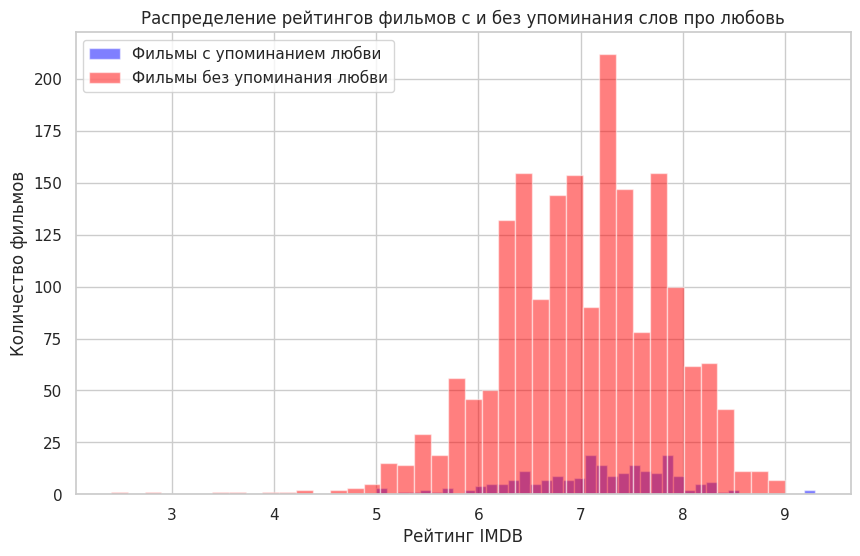

H_0 гипотеза: фильмы, в описании которых есть война хуже по рейтингу
p_value =  0.038285383064068666
Есть статистически значимая разница в рейтинге между фильмами с упоминанием слов про войну и без таких упоминаний.


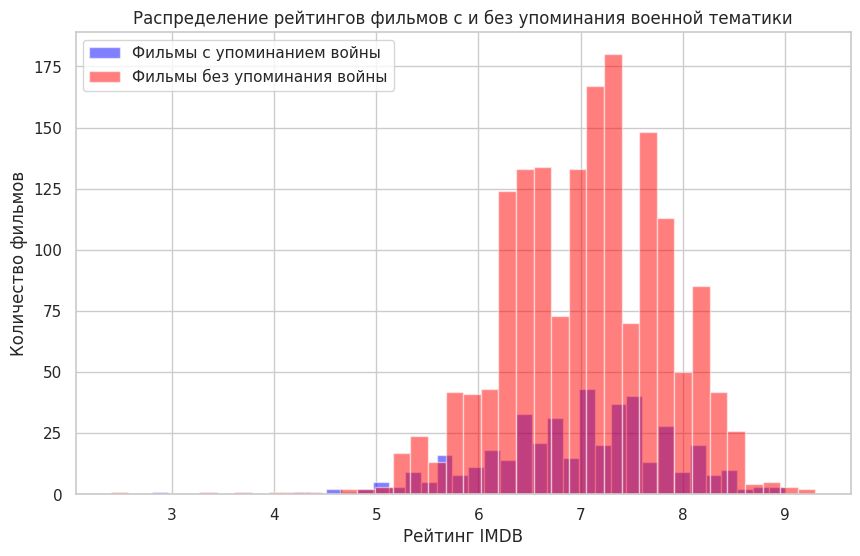

H_0 гипотеза: фильмы, в описании которых есть брат хуже по рейтингу
p_value =  0.1994094753696981
Нет статистически значимой разницы в рейтинге между фильмами с упоминанием слова 'brother' и общим средним рейтингом.


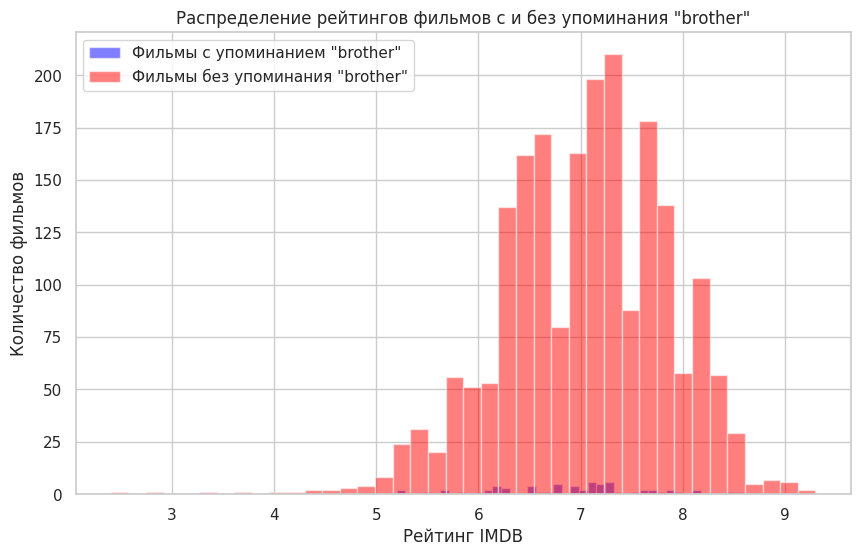

In [37]:
print('H_0 гипотеза: фильмы, в описании которых есть любовь лучше по рейтингу')
# Создаем бинарный столбец, указывающий, есть ли в описании фильма слова про любовь
df_filtered['has_love_keywords'] = df_filtered['description'].apply(lambda x: any(word in x for word in love_word_list))

# Разделяем рейтинги фильмов на две группы: с упоминанием слов про любовь и без таких упоминаний
films_with_love = df_filtered[df_filtered['has_love_keywords']]
films_without_love = df_filtered[~df_filtered['has_love_keywords']]

# Выполняем двухвыборочный t-тест для сравнения рейтингов двух групп
alpha = 0.05
t_statistic, p_value = sts.ttest_ind(films_with_love['imdb_rate'], films_without_love['imdb_rate'])

# Выводим результаты теста
print('p_value = ', p_value)
if p_value < alpha:
    print("Есть статистически значимая разница в рейтинге между фильмами с упоминанием слов про любовь и без таких упоминаний.")
else:
    print("Нет статистически значимой разницы в рейтинге между фильмами с упоминанием слов про любовь и без таких упоминаний.")

# Построение гистограмм распределения количества фильмов с упоминанием и без упоминаний слов про любовь
plt.figure(figsize=(10, 6))
plt.hist(films_with_love['imdb_rate'], bins=40, color='blue', alpha=0.5, label='Фильмы с упоминанием любви')
plt.hist(films_without_love['imdb_rate'], bins=40, color='red', alpha=0.5, label='Фильмы без упоминания любви')


plt.xlabel('Рейтинг IMDB')
plt.ylabel('Количество фильмов')
plt.title('Распределение рейтингов фильмов с и без упоминания слов про любовь')
plt.legend()
plt.show()

#__________________________
print('H_0 гипотеза: фильмы, в описании которых есть война хуже по рейтингу')
# Создаем бинарный столбец, указывающий, есть ли в описании слова про войну
df_filtered['has_war_keywords'] = df_filtered['description'].apply(lambda x: any(word in x for word in war_word_list))

# Разделяем рейтинги фильмов на две группы: с упоминанием слов про войну и без таких упоминаний
films_with_war = df_filtered[df_filtered['has_war_keywords']]
films_without_war = df_filtered[~df_filtered['has_war_keywords']]

# Выполняем двухвыборочный t-тест для сравнения рейтингов двух групп
alpha = 0.05
t_statistic, p_value = sts.ttest_ind(films_with_war['imdb_rate'], films_without_war['imdb_rate'])

# Проверяем статистическую значимость различия рейтингов
print('p_value = ', p_value)
if p_value < alpha:
    print("Есть статистически значимая разница в рейтинге между фильмами с упоминанием слов про войну и без таких упоминаний.")
else:
    print("Нет статистически значимой разницы в рейтинге между фильмами с упоминанием слов про войну и без таких упоминаний.")

# Выбираем рейтинги фильмов с упоминанием слова 'brother'
films_with_war = df_filtered[df_filtered['has_war_keywords']]['imdb_rate']

# Выбираем рейтинги фильмов без упоминания слова 'brother'
films_without_war = df_filtered[~df_filtered['has_war_keywords']]['imdb_rate']

# Создаем гистограммы
plt.figure(figsize=(10, 6))
plt.hist(films_with_war, bins=40, color='blue', alpha=0.5, label='Фильмы с упоминанием войны')
plt.hist(films_without_war, bins=40, color='red', alpha=0.5, label='Фильмы без упоминания войны')

# Настройка осей и заголовка
plt.xlabel('Рейтинг IMDB')
plt.ylabel('Количество фильмов')
plt.title('Распределение рейтингов фильмов с и без упоминания военной тематики')
plt.legend()

# Отображение гистограммы
plt.show()

#_________________
print('H_0 гипотеза: фильмы, в описании которых есть брат хуже по рейтингу')
# Создаем бинарный столбец, указывающий, есть ли в описании слово 'brother'
df_filtered['has_brother_keyword'] = df_filtered['description'].apply(lambda x: 'brother' in x)

# Выбираем рейтинги фильмов с упоминанием слова 'brother'
films_with_brother = df_filtered[df_filtered['has_brother_keyword']]['imdb_rate']

# Выполняем одновыборочный t-тест для сравнения рейтингов фильмов с упоминанием слова 'brother'
alpha = 0.05
t_statistic, p_value = sts.ttest_1samp(films_with_brother, df_filtered['imdb_rate'].mean())

# Проверяем статистическую значимость различия рейтингов
print('p_value = ', p_value)
if p_value < alpha:
    print("Статистически значимая разница в рейтинге между фильмами с упоминанием слова 'brother' и общим средним рейтингом.")
else:
    print("Нет статистически значимой разницы в рейтинге между фильмами с упоминанием слова 'brother' и общим средним рейтингом.")

# Выбираем рейтинги фильмов с упоминанием слова 'brother'
films_with_brother = df_filtered[df_filtered['has_brother_keyword']]['imdb_rate']

# Выбираем рейтинги фильмов без упоминания слова 'brother'
films_without_brother = df_filtered[~df_filtered['has_brother_keyword']]['imdb_rate']

# Создаем гистограммы
plt.figure(figsize=(10, 6))
plt.hist(films_with_brother, bins=40, color='blue', alpha=0.5, label='Фильмы с упоминанием "brother"')
plt.hist(films_without_brother, bins=40, color='red', alpha=0.5, label='Фильмы без упоминания "brother"')

# Настройка осей и заголовка
plt.xlabel('Рейтинг IMDB')
plt.ylabel('Количество фильмов')
plt.title('Распределение рейтингов фильмов с и без упоминания "brother"')
plt.legend()

# Отображение гистограммы
plt.show()

### Результаты проверки гипотез:

1. Принимаем — Фильмы, в описании которых есть любовь лучше по рейтингу
2. Принимаем — Фильмы с упоминанием войны в описании имеют рейтинг ниже среднего
3. Отвергаем — Фильмы с упоминанием брата ('brother') в описании имеют рейтинг ниже среднего

### Еще полезное

посмотрели, как распределены оценки фильмов по количеству голосов

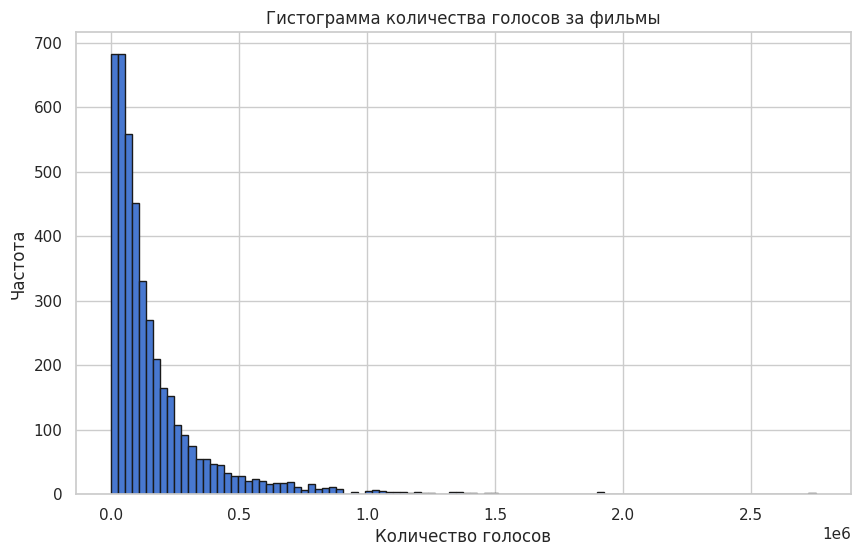

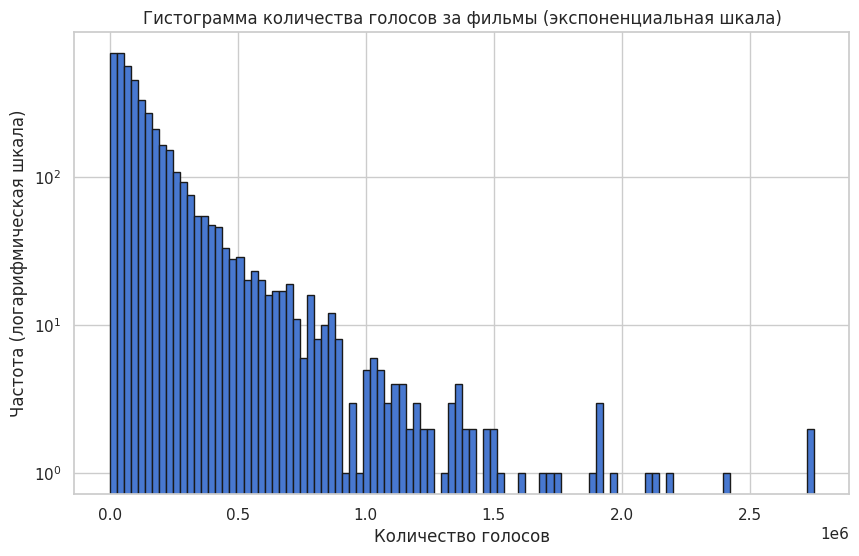

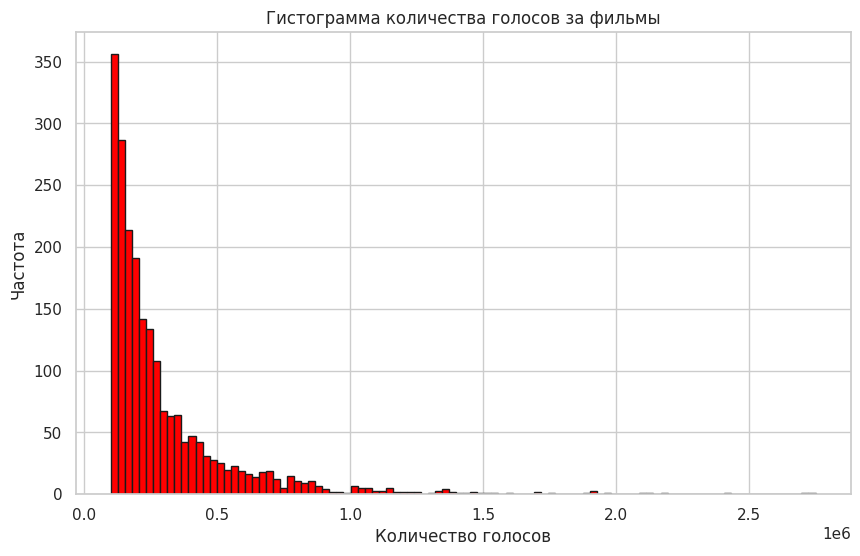

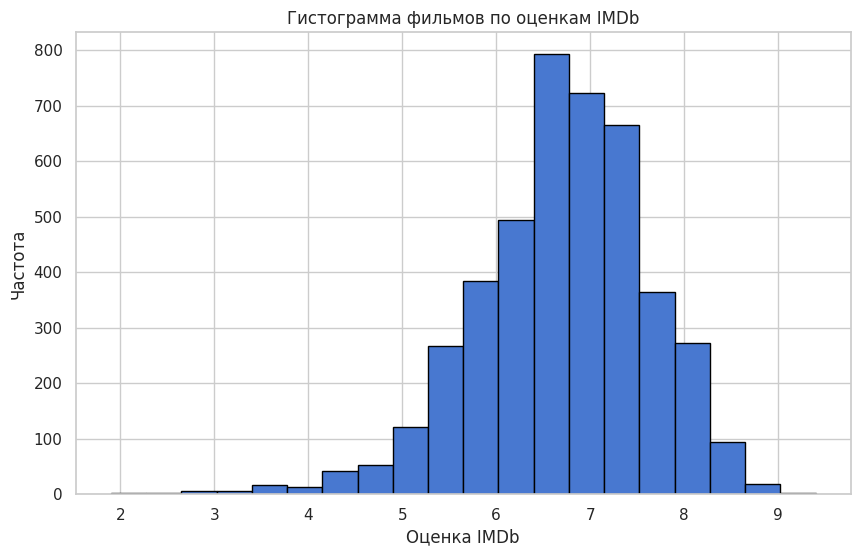

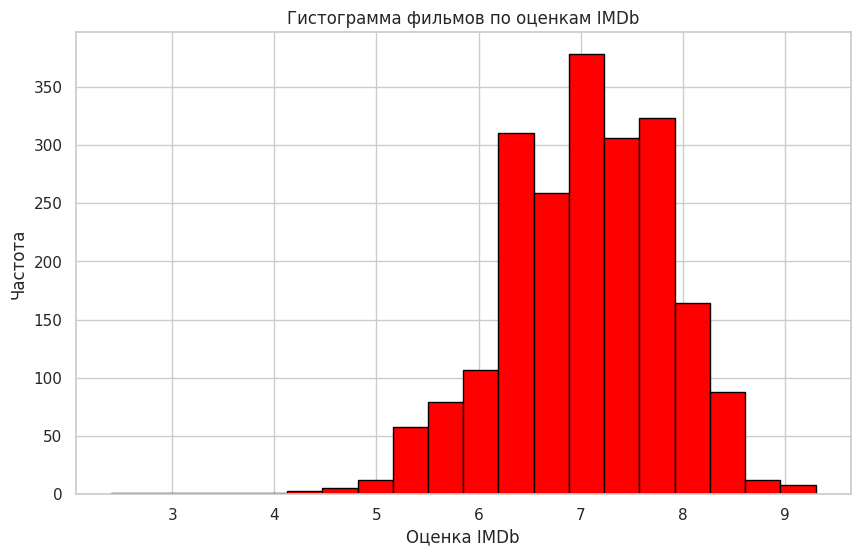

In [64]:
# №5 начало: строю графиик распредления количества голосов за фильмы от их оценок
df = pd.read_csv('/content/result.csv')

# Создаем гистограмму
plt.figure(figsize=(10, 6))
plt.hist(df['votes'], bins=100, edgecolor='k')  # Задаем количество бинов и цвет границы столбцов
plt.xlabel('Количество голосов')
plt.ylabel('Частота')
plt.title('Гистограмма количества голосов за фильмы')

plt.figure(figsize=(10, 6))
plt.hist(df['votes'], bins=100, edgecolor='k')  # Задаем количество бинов и цвет границы столбцов
plt.yscale('log')  # Установка логарифмической шкалы по оси y
plt.xlabel('Количество голосов')
plt.ylabel('Частота (логарифмическая шкала)')
plt.title('Гистограмма количества голосов за фильмы (экспоненциальная шкала)')
plt.show()

# Отображаем гистограмму
plt.show()

df_filtered = df[df['votes'] >= 100000]

# Создаем гистограмму
plt.figure(figsize=(10, 6))
plt.hist(df_filtered['votes'], bins=100, edgecolor='k', color = 'red')  # Задаем количество бинов и цвет границы столбцов
plt.xlabel('Количество голосов')
plt.ylabel('Частота')
plt.title('Гистограмма количества голосов за фильмы')


# Отображаем гистограмму
plt.show()

df["imdb_rate"] = df["imdb_rate"].str.replace(',', '.').astype(float)
df_filtered = df[df['votes'] >= 100000]

plt.figure(figsize=(10, 6))
plt.hist(df['imdb_rate'], bins=20, edgecolor='black')
plt.xlabel('Оценка IMDb')
plt.ylabel('Частота')
plt.title('Гистограмма фильмов по оценкам IMDb')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(df_filtered['imdb_rate'], bins=20, edgecolor='black', color = 'red')
plt.xlabel('Оценка IMDb')
plt.ylabel('Частота')
plt.title('Гистограмма фильмов по оценкам IMDb')
plt.show()

# Создаем список уникальных жанров
genres = set()
for genre_list in df['genre']:
    genres.update(genre_list.split(', '))

# Обновляем значения столбцов жанров
for index, row in df.iterrows():
    genre_list = row['genre'].split(', ')
    for genre in genre_list:
        df.at[index, genre] = 1